#### Importing all libraries

In [36]:
import pandas as PD
import seaborn as SNS
import matplotlib.pyplot as PLT
import numpy as NP
from numpy import sum

In [37]:
custom_colours = ['#74a09e','#98e2c6','#f2a553','#c14953']
SNS.set_theme(style="whitegrid",palette=custom_colours)

#### Loading the dataset

In [38]:
raw_data = PD.read_csv("50_Startups.csv", sep=";")
data = raw_data.copy()

#### Initial data exploration

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   R&D             50 non-null     float64
 1   Administration  50 non-null     float64
 2   Marketing       50 non-null     float64
 3   villes          50 non-null     object 
 4   Profit          50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


This dataset has **50** entries in **5** columns. It has **no missing data**. **4** columns are **numerical** and **1** column is **categorical**.

In [40]:
data.head()

,R&D,Administration,Marketing,villes,Profit
0,165349.20,136897.80,471784.10,Paris,192261.83
1,162597.70,151377.59,443898.53,Strasbourg,191792.06
2,153441.51,101145.55,407934.54,Lyon,191050.39
3,144372.41,118671.85,383199.62,Paris,182901.99
4,142107.34,91391.77,366168.42,Lyon,166187.94


Columns are ordered as follows:
- **3** columns detailing the **budget** each startup grants to each of their departments: **R&D**, **Administration** and **Marketing**.
- **1** column detailing the **location** where the startup supposedly operates from.
- **1** column detailing the **profit** each startup has made over an **unknown timespan**.

Paris         17
Strasbourg    17
Lyon          16
Name: villes, dtype: int64


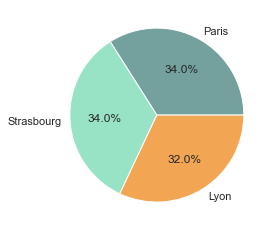

In [41]:
print(data["villes"].value_counts())
PLT.pie(data["villes"].value_counts(),labels=data["villes"].unique(),autopct='%1.1f%%')
PLT.show()

We see here that we can order the dataset by the **'villes'** column since it is balanced around those values, with an even spread between all three of the cities found in that column : **Strasbourg**, **Paris** and **Lyon**.

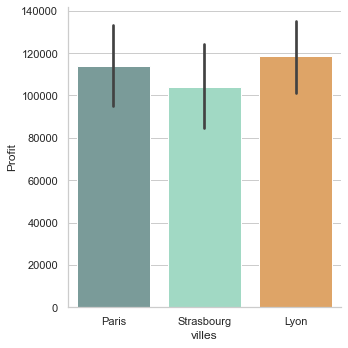

In [42]:
SNS.catplot(data=data,kind="bar",x="villes",y="Profit")
PLT.show()

We can see from this graph that, at face value, the "best" city to operate from is **Lyon** since it boasts both the highest **average profit** and **maximum profit**.

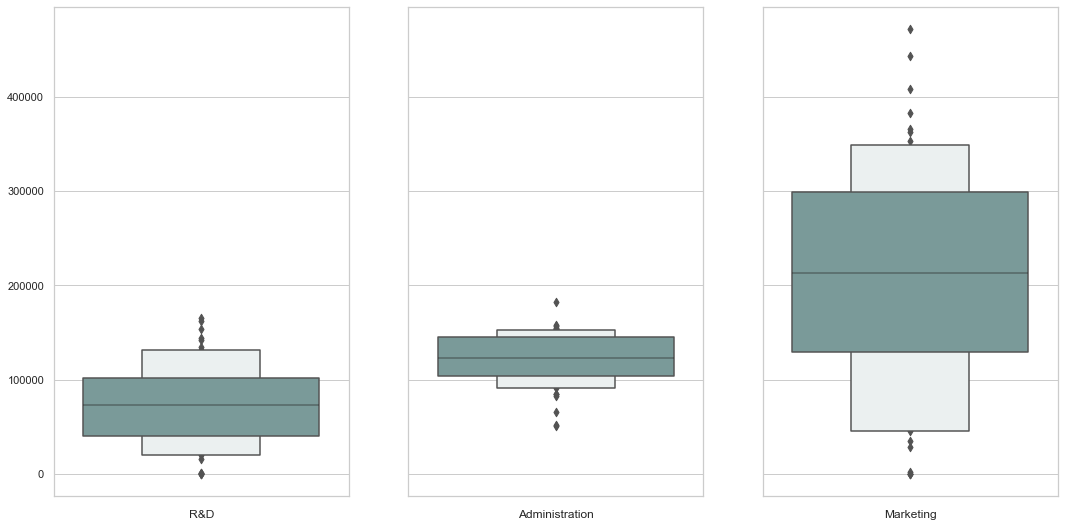

In [43]:
fig, ax = PLT.subplots(1,3,figsize=(18,9),sharey=True)
SNS.boxenplot(data=data,y="R&D",ax=ax[0])
ax[0].set_xlabel("R&D")
ax[0].set_ylabel("")
SNS.boxenplot(data=data,y="Administration",ax=ax[1])
ax[1].set_xlabel("Administration")
ax[1].set_ylabel("")
SNS.boxenplot(data=data,y="Marketing",ax=ax[2])
ax[2].set_xlabel("Marketing")
ax[2].set_ylabel("")
PLT.show()

By far, the highest budget allocation goes to the marketing department, it also demonstrates that there is a large variety of investment strategies for marketing whereas the budget for administration seems to have been figured out by most, as if they all shared a similar template; the same cannot be said for R&D but its overall budget remains the lowest across the board.

In [44]:
data.corr()

,R&D,Administration,Marketing,Profit
R&D,1.000000,0.241955,0.724248,0.972900
Administration,0.241955,1.000000,-0.032154,0.200717
Marketing,0.724248,-0.032154,1.000000,0.747766
Profit,0.972900,0.200717,0.747766,1.000000


At first glance, we can see a strong correlation between R&D and Profit, a significant correlation between Marketing and Profit and almost none between Administration and Profit. This is not unexpected since the administration department cannot be expected to have as direct an impact on profit.

#### Study of correlations

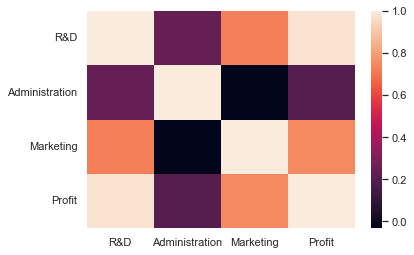

In [45]:
SNS.heatmap(data.corr())
PLT.show()

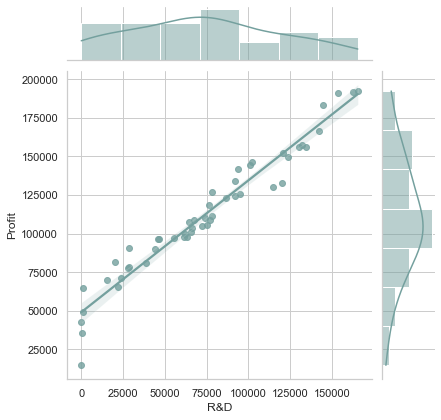

In [46]:
SNS.jointplot(x="R&D",y="Profit",kind="reg",data=data)
PLT.show()

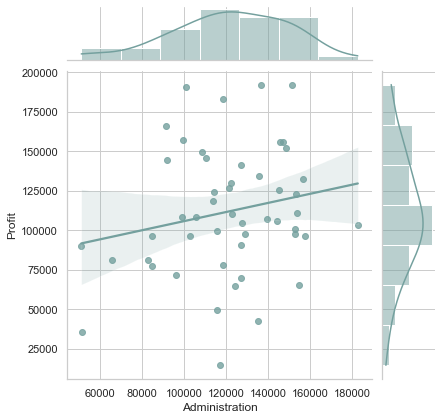

In [47]:
SNS.jointplot(x="Administration",y="Profit",kind="reg",data=data)
PLT.show()

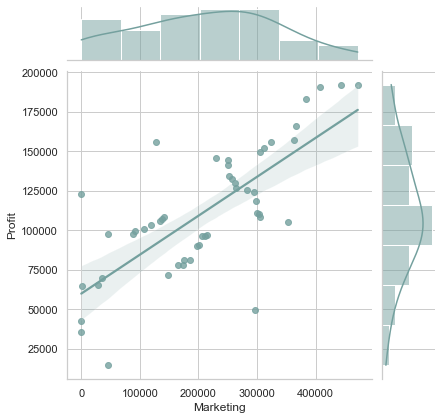

In [48]:
SNS.jointplot(x="Marketing",y="Profit",kind="reg",data=data)
PLT.show()

In [49]:
data["Budget"] = data["R&D"]+data["Administration"]+data["Marketing"]
data.head()

,R&D,Administration,Marketing,villes,Profit,Budget
0,165349.20,136897.80,471784.10,Paris,192261.83,774031.10
1,162597.70,151377.59,443898.53,Strasbourg,191792.06,757873.82
2,153441.51,101145.55,407934.54,Lyon,191050.39,662521.60
3,144372.41,118671.85,383199.62,Paris,182901.99,646243.88
4,142107.34,91391.77,366168.42,Lyon,166187.94,599667.53


We decide to sum up all bugdets together in a new 'Budget' column to see the correlation between the overall budget of a startup and their profit. We expect a loss in precision in our model.

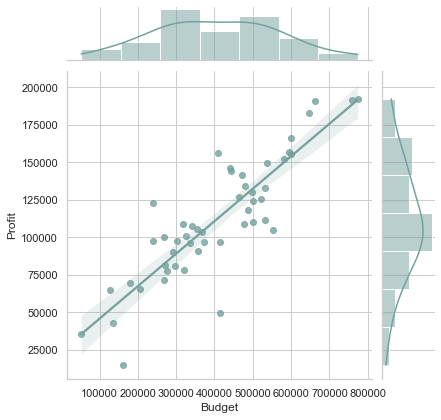

In [50]:
SNS.jointplot(x="Budget",y="Profit",kind="reg",data=data)
PLT.show()

Correlation with new features

In [51]:
data.corr()

,R&D,Administration,Marketing,Profit,Budget
R&D,1.000000,0.241955,0.724248,0.972900,0.869663
Administration,0.241955,1.000000,-0.032154,0.200717,0.216674
Marketing,0.724248,-0.032154,1.000000,0.747766,0.952069
Profit,0.972900,0.200717,0.747766,1.000000,0.872598
Budget,0.869663,0.216674,0.952069,0.872598,1.000000


Expectedly, the idea that you need to 'spend money to make money' seems to be holding true, with an almost normal distribution of our values.

#### Linear Regression Model(s)

##### Importing all machine learning libraries

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

##### Choosing our features and target

In [53]:
LR = LinearRegression()
X = data.loc[:,data.columns != 'Profit'].copy()
ohe_encoder = OneHotEncoder(sparse=False, drop='first')
encoded_villes = ohe_encoder.fit_transform(PD.DataFrame(data.loc[:,'villes']))
encoded_villes_df = PD.DataFrame(encoded_villes, columns=ohe_encoder.get_feature_names_out())
X = PD.concat([X,encoded_villes_df],axis=1).drop('villes',axis=1)
#X.drop("villes",axis=1,inplace=True)
y = data['Profit'].copy()
X.head()

,R&D,Administration,Marketing,Budget,villes_Paris,villes_Strasbourg
0,165349.20,136897.80,471784.10,774031.10,1.0,0.0
1,162597.70,151377.59,443898.53,757873.82,0.0,1.0
2,153441.51,101145.55,407934.54,662521.60,0.0,0.0
3,144372.41,118671.85,383199.62,646243.88,1.0,0.0
4,142107.34,91391.77,366168.42,599667.53,0.0,0.0


We have decided to encode and use the "villes" feature.

Creating the training and testing datasets

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=666)

##### Reinventing the wheel

In [55]:
def R2_AdjR2(y,f,nb_features):
    p = nb_features
    n = len(y)
    SSres = 0
    for i in range(n):
        ei = y[i] - f[i]
        SSres += ei**2
    y_ = (1/n)*sum(y)
    SStot = 0
    for i in range(n):
        SStot += (y[i]-y_)**2
    R2 = 1 - (SSres/SStot)
    dfe = n-p-1
    dft = n-1
    adj_R2 = 1 - (SSres/dfe)/(SStot/dft) # adj_R2 = 1 - (1-R2)*(n-1)/(n-p-1)
    return R2, adj_R2

##### Training and scoring the Linear Regression model

In [56]:
LR.fit(X_train,y_train)
predictions = LR.predict(X_test)
res_df = PD.DataFrame(dict(R_et_D=X_test["R&D"],Administration=X_test['Administration'],Marketing=X_test['Marketing'], Budget=X_test['Budget'],Paris=X_test['villes_Paris'], Strasbourg=X_test['villes_Strasbourg'],y_true=y_test,y_pred=predictions))
Y = NP.array(y_test)
f = NP.array(predictions)
R2, adj_R2 = R2_AdjR2(Y,f,LR.n_features_in_)
print(f"R²:\n{R2}\n")
print(f"Adjusted R²:\n{adj_R2}\n")
print(f"Explained Variance Score:\n{explained_variance_score(y_test,predictions)}\n")
print(f"Coefficients:\n{LR.coef_}\n")
print(f"MAE:\n{mean_absolute_error(y_test, predictions)}\n")
print(f"MSE:\n{mean_squared_error(y_test, predictions)}\n")
print(f"RMSE:\n{mean_squared_error(y_test, predictions)**(1/2)}")

R²:
0.9212780962296645

Adjusted R²:
0.8622366684019128

Explained Variance Score:
0.9233383147961707

Coefficients:
[ 5.80986967e-01 -2.41500340e-01 -1.66354106e-01  1.73132497e-01
 -1.99757143e+03  1.54316901e+03]

MAE:
11138.985742242363

MSE:
234776710.33246106

RMSE:
15322.425080008094


##### Comparing our predictions, for each feature, with the true values

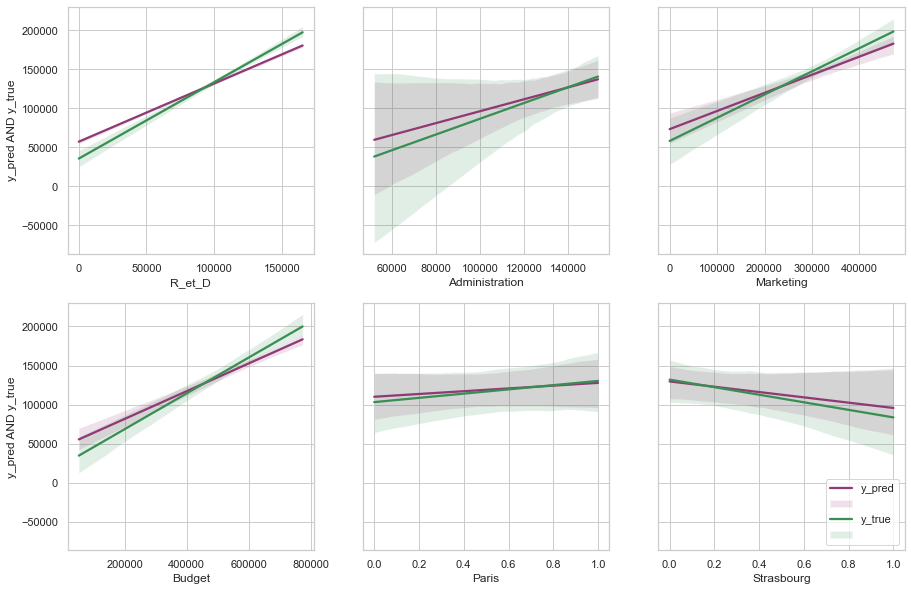

In [57]:
fig, ax = PLT.subplots(2,3,figsize=(15,10), sharey=True)
SNS.regplot(x="R_et_D",y="y_pred",data=res_df, ax=ax[0,0], color="#8F3975", scatter=False)
SNS.regplot(x="R_et_D",y="y_true",data=res_df, ax=ax[0,0], color="#398F53", scatter=False)
ax[0,0].set_ylabel("y_pred AND y_true")

SNS.regplot(x="Administration",y="y_pred",data=res_df, ax=ax[0,1], color="#8F3975", scatter=False)
SNS.regplot(x="Administration",y="y_true",data=res_df, ax=ax[0,1], color="#398F53", scatter=False)
ax[0,1].set_ylabel("")

SNS.regplot(x="Marketing",y="y_pred",data=res_df, ax=ax[0,2], color="#8F3975", scatter=False)
SNS.regplot(x="Marketing",y="y_true",data=res_df, ax=ax[0,2], color="#398F53", scatter=False)
ax[0,2].set_ylabel("")

SNS.regplot(x="Budget",y="y_pred",data=res_df, ax=ax[1,0], color="#8F3975", scatter=False)
SNS.regplot(x="Budget",y="y_true",data=res_df, ax=ax[1,0], color="#398F53", scatter=False)
ax[1,0].set_ylabel("y_pred AND y_true")

SNS.regplot(x="Paris",y="y_pred",data=res_df, ax=ax[1,1], color="#8F3975", scatter=False)
SNS.regplot(x="Paris",y="y_true",data=res_df, ax=ax[1,1], color="#398F53", scatter=False)
ax[1,1].set_ylabel("")

SNS.regplot(x="Strasbourg",y="y_pred",data=res_df, ax=ax[1,2], color="#8F3975", scatter=False)
SNS.regplot(x="Strasbourg",y="y_true",data=res_df, ax=ax[1,2], color="#398F53", scatter=False)
ax[1,2].set_ylabel("")
PLT.legend(labels=["y_pred","","y_true",""], loc=4)
PLT.show()

These graphs show that the 'Administration' and 'villes' features could be introducing some bias. We will confirm our intuition with several tests.

RFE

In [58]:
estimator_svr = SVR(kernel="linear")
selector_svr = RFE(estimator_svr)
selector_svr = selector_svr.fit(X, y)

print(f'SVR:')
print(f'{selector_svr.support_}')
print(f'{selector_svr.ranking_}\n')

estimator_tree= DecisionTreeRegressor()
selector_tree = RFE(estimator_tree)
selector_tree = selector_tree.fit(X, y)

print(f'Tree:')
print(f'{selector_tree.support_}')
print(f'{selector_tree.ranking_}')

SVR:
[ True False False False  True  True]
[1 4 3 2 1 1]

Tree:
[ True False  True  True False False]
[1 2 1 1 4 3]


F-ANOVA

In [59]:
f_statistic, p_values = f_regression(X,y)
print(f"F values:\n{f_statistic}\n")
print(f"P values:\n{p_values}")

F values:
[8.49788904e+02 2.01495972e+00 6.08814545e+01 1.53196169e+02
 4.72749794e-02 1.04306966e+00]

P values:
[3.50032224e-32 1.62217395e-01 4.38107318e-10 1.50826749e-16
 8.28796347e-01 3.12228656e-01]


K-BEST

In [60]:
X_kbest = SelectKBest(f_regression, k=4).fit(X, y)
print(X_kbest.get_feature_names_out())

['R&D' 'Administration' 'Marketing' 'Budget']


In [61]:
X.drop(columns=['villes_Paris','villes_Strasbourg']).corr()

,R&D,Administration,Marketing,Budget
R&D,1.000000,0.241955,0.724248,0.869663
Administration,0.241955,1.000000,-0.032154,0.216674
Marketing,0.724248,-0.032154,1.000000,0.952069
Budget,0.869663,0.216674,0.952069,1.000000


After a few tests during our feature selection, we can remove the encoded columns, thus confirming our initial intuition that we should not be using the 'villes' column.

##### Training and scoring the Linear Regression model with the new set of features

In [62]:
LR_A = LinearRegression()
Xa = X.drop(columns=['villes_Paris','villes_Strasbourg'])
Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa,y,test_size=.3,random_state=666)
LR_A.fit(Xa_train,ya_train)
A_predictions = LR_A.predict(Xa_test)
res_df = PD.DataFrame(dict(R_et_D=Xa_test["R&D"],Administration=Xa_test['Administration'],Marketing=Xa_test['Marketing'], Budget=Xa_test['Budget'],y_true=ya_test,y_pred=A_predictions))
Y = NP.array(ya_test)
f = NP.array(A_predictions)
R2, adj_R2 = R2_AdjR2(Y,f,LR_A.n_features_in_)
print(f"R²:\n{R2}\n")
print(f"Adjusted R²:\n{adj_R2}\n")
print(f"Explained Variance Score:\n{explained_variance_score(ya_test,A_predictions)}\n")
print(f"Coefficients:\n{LR_A.coef_}")
print(f"MAE:\n{mean_absolute_error(ya_test, A_predictions)}\n")
print(f"MSE:\n{mean_squared_error(ya_test, A_predictions)}\n")
print(f"RMSE:\n{mean_squared_error(ya_test, A_predictions)**(1/2)}")

R²:
0.9276077903491879

Adjusted R²:
0.8986509064888631

Explained Variance Score:
0.9304308321988444

Coefficients:
[-1.63157713e+12 -1.63157713e+12 -1.63157713e+12  1.63157713e+12]
MAE:
10553.654065014047

MSE:
215899311.6464752

RMSE:
14693.512570058774


When compared with the previous **adjusted R² score** *(0.8622366684019128)* we see an improvement of ~3%; however, we have a feeling we can improve our model further.


##### Comparing our predictions, for each feature, with the true values

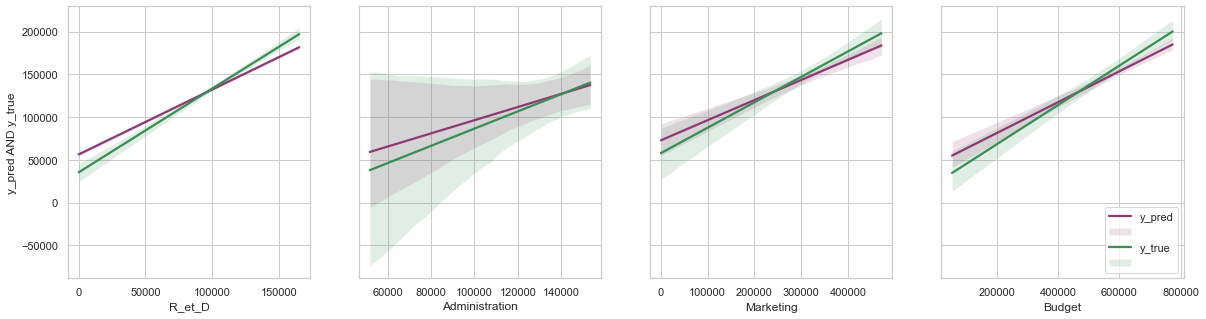

In [63]:
fig, ax = PLT.subplots(1,4,figsize=(20,5), sharey=True)
SNS.regplot(x="R_et_D",y="y_pred",data=res_df, ax=ax[0], color="#8F3975", scatter=False)
SNS.regplot(x="R_et_D",y="y_true",data=res_df, ax=ax[0], color="#398F53", scatter=False)
ax[0].set_ylabel("y_pred AND y_true")

SNS.regplot(x="Administration",y="y_pred",data=res_df, ax=ax[1], color="#8F3975", scatter=False)
SNS.regplot(x="Administration",y="y_true",data=res_df, ax=ax[1], color="#398F53", scatter=False)
ax[1].set_ylabel("")

SNS.regplot(x="Marketing",y="y_pred",data=res_df, ax=ax[2], color="#8F3975", scatter=False)
SNS.regplot(x="Marketing",y="y_true",data=res_df, ax=ax[2], color="#398F53", scatter=False)
ax[2].set_ylabel("")

SNS.regplot(x="Budget",y="y_pred",data=res_df, ax=ax[3], color="#8F3975", scatter=False)
SNS.regplot(x="Budget",y="y_true",data=res_df, ax=ax[3], color="#398F53", scatter=False)
ax[3].set_ylabel("")
PLT.legend(labels=["y_pred","","y_true",""], loc=4)
PLT.show()

##### Second round of features selection

In [64]:
X_kbest = SelectKBest(f_regression, k=2).fit(Xa, y)
print(X_kbest.get_feature_names_out())

['R&D' 'Budget']


##### Training the new model

In [65]:
LR_B = LinearRegression()
Xb = Xa.drop(columns=['Marketing','Administration'])
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb,y,test_size=.3,random_state=666)
LR_B.fit(Xb_train,yb_train)
B_predictions = LR_B.predict(Xb_test)
res_df = PD.DataFrame(dict(R_et_D=Xb_test["R&D"], Budget=Xb_test['Budget'],y_true=yb_test,y_pred=B_predictions))
Y = NP.array(yb_test)
f = NP.array(B_predictions)
R2, adj_R2 = R2_AdjR2(Y,f,LR_B.n_features_in_)
print(f"R²:\n{R2}\n")
print(f"Adjusted R²:\n{adj_R2}\n")
print(f"Explained Variance Score:\n{explained_variance_score(yb_test,B_predictions)}\n")
print(f"Coefficients:\n{LR_A.coef_}")
print(f"MAE:\n{mean_absolute_error(yb_test, B_predictions)}\n")
print(f"MSE:\n{mean_squared_error(yb_test, B_predictions)}\n")
print(f"RMSE:\n{mean_squared_error(yb_test, B_predictions)**(1/2)}")

R²:
0.9315658295339724

Adjusted R²:
0.9201601344563011

Explained Variance Score:
0.9361502971240554

Coefficients:
[-1.63157713e+12 -1.63157713e+12 -1.63157713e+12  1.63157713e+12]
MAE:
10267.976329463738

MSE:
204095031.32975808

RMSE:
14286.183231701814


When compared with the previous **adjusted R² score** *(0.8986509064888631)* we see an improvement of ~3% again; however, with the model down to only two features, we can't go any further.

##### Comparing our predictions, for each feature, with the true values

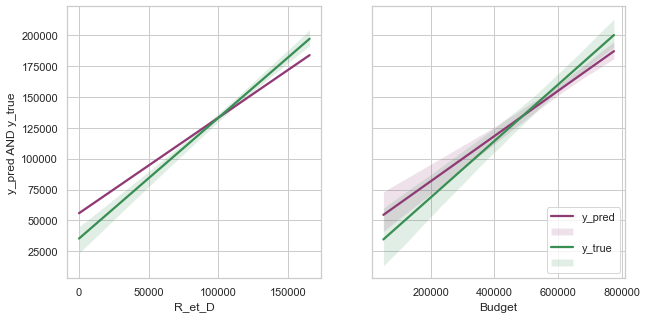

In [66]:
fig, ax = PLT.subplots(1,2,figsize=(10,5), sharey=True)
SNS.regplot(x="R_et_D",y="y_pred",data=res_df, ax=ax[0], color="#8F3975", scatter=False)
SNS.regplot(x="R_et_D",y="y_true",data=res_df, ax=ax[0], color="#398F53", scatter=False)
ax[0].set_ylabel("y_pred AND y_true")

SNS.regplot(x="Budget",y="y_pred",data=res_df, ax=ax[1], color="#8F3975", scatter=False)
SNS.regplot(x="Budget",y="y_true",data=res_df, ax=ax[1], color="#398F53", scatter=False)
ax[1].set_ylabel("")
PLT.legend(labels=["y_pred","","y_true",""], loc=4)
PLT.show()

The new model is **objectively** better, thus we'll use it for the prediction.

In [67]:
R_n_D_budget = 65135
Marketing_budget = 353000
Administration_budget = 150000
Budget_budget = R_n_D_budget + Marketing_budget + Administration_budget

big_dict = {"R&D":R_n_D_budget,"Budget":Budget_budget}
x_try = PD.DataFrame(big_dict, index=[0])
x_try.head()

,R&D,Budget
0,65135,568135


In [68]:
try_predict = LR_B.predict(x_try)
print(try_predict)

[107773.52488432]


### Rapport

- **Nom:** Victorino, Thiberino
- **Date:** Oui.
- **Cible client:** Non. 

**Contexte:**
> "La BPI France dispose d'un fond d'investissement qu'elle voudrait utiliser pour investir dans les start'up de demain les plus
prometteuses. Seulement elle ne sait pas comment les sélectionner. 
Faut-il investir dans celles qui dépensent le plus en marketing? en recherche et développement? dans quelles villes les startups semblent mieux opérer? Elle fait donc appel à vous pour y voir plus clair..."

**Objectif:**
> "Vous devez donc concevoir un modèle de régression linéaire multiple qui permettra à la BPI d'une part de sélectionner les 5
start'up les plus prometteuses et d'autre part de déterminer dans quel(s) secteur(s) il serait le plus judicieux de répartir les
budgets de dépenses."

*Faut-il investir dans les entreprises qui dépensent le plus en marketing ou en recherche et développement?*

In [69]:
data_1 = data.copy()
data_1.drop("Administration",axis=1,inplace=True)
data_1.drop("villes",axis=1,inplace=True)
data_1.drop("Budget",axis=1,inplace=True)
data_1.sort_values(by="Profit",ascending=False)
print(f"Max Marketing:\n{data_1['Marketing'].max()}")
print(f"Max R&D:\n{data_1['R&D'].max()}")
data_1.head()

Max Marketing:
471784.1
Max R&D:
165349.2


,R&D,Marketing,Profit
0,165349.20,471784.10,192261.83
1,162597.70,443898.53,191792.06
2,153441.51,407934.54,191050.39
3,144372.41,383199.62,182901.99
4,142107.34,366168.42,166187.94


Au vu de la forte correlation entre ces deux features, investir dans l'un ou l'autre ménera à l'augmentation des profits.

*Dans quelles villes les startups semblent elles mieux opérer?*

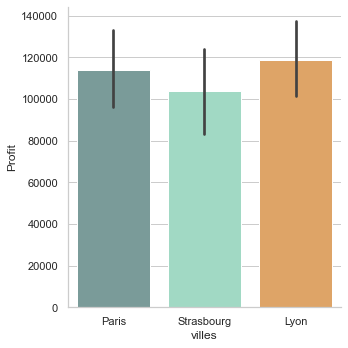

In [70]:
SNS.catplot(data=data,kind="bar", x="villes", y="Profit")
PLT.show()

Lyon est plus profitable que Paris qui est plus profitable que Strasbourg.

En conclusion, si les postes de dépenses sont fortement corrélés avec le profit, il est presque assuré que le profit augmente si le budget augmente *(dans des conditions idéales)*. Investir dans le R&D offre un meilleur retour sur investissement.